In [3]:
# lstm

from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, SimpleRNN

import numpy as np

In [4]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction

print(dataset.head(30))

#dewp dew point
#pm2.5 pollution measure
#cbwd wind direction
#Iws cumulated wind speed
#Is cumulated hours of snow
#Ir cumulated hours of rain

np.shape(values)

    year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
No                                                                       
1   2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2   2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
3   2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
4   2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
5   2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
6   2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
7   2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
8   2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
9   2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0
11  2010      1    1    10    NaN   -19  -7.0  1017.0   NW  31.30   0   0
12  2010      1    1    11    NaN   -1

(43824, 12)

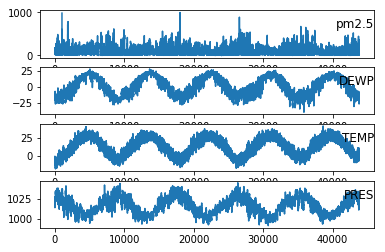

<Figure size 28800x28800 with 0 Axes>

In [5]:
# specify columns to plot
groups = [  4,5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.figure(figsize=(400,400))
plt.show()

In [6]:
# Prepare dataset: supervised learning (pollution at previous timestep and weather conditions)
# 

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) #
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    #print(cols)
    agg = concat(cols, axis=1)
    #print(agg)
    agg.columns = names
    #print(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        #print(np.shape(agg))
    return agg

In [90]:
#for i in range(8,0,-1):
#    print(i)
print(n_hours)    
#len(DataFrame(scaled).shift(3))
series_to_supervised(scaled[:20], n_hours, 1)

4


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)


In [7]:
# integer encode direction
encoder = LabelEncoder()
values[:,8] = encoder.fit_transform(values[:,8])

In [8]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
# specify the number of lag hours
n_hours = 1
# frame as supervised learning
reframed = series_to_supervised(scaled[:,4:], n_hours, 1)
print(reframed.shape)
#reframed #now contains also the variables at previous time steps

(41543, 16)


In [80]:
n_obs

32

In [10]:
# split into train and test sets
n_features = 8
values = reframed.values
print('shape values')
print(np.shape(values))
print(values[0])
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
print('shape train')
print(np.shape(train))
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
print('shape train_X')
print(np.shape(train_X))
print('shape train_y')
print(np.shape(train_y))
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

shape values
(41543, 16)
[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
 0.         0.         0.14889336 0.36764708 0.24590163 0.5272732
 0.6666667  0.00381099 0.         0.        ]
shape train
(8760, 16)
shape train_X
(8760, 8)
shape train_y
(8760,)
(8760, 1, 8) (8760,) (32783, 1, 8) (32783,)


In [11]:
# design network
modelr = Sequential()
modelr.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
modelr.add(Dense(1))
modelr.compile(loss='mae', optimizer='adam')
modelr.summary()

W0601 10:46:29.106267 4599520704 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit network
historyr = modelr.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 32783 samples
Epoch 1/30
8760/8760 - 1s - loss: 0.0563 - val_loss: 0.0904
Epoch 2/30
8760/8760 - 1s - loss: 0.0289 - val_loss: 0.0668
Epoch 3/30
8760/8760 - 1s - loss: 0.0196 - val_loss: 0.0448
Epoch 4/30
8760/8760 - 1s - loss: 0.0165 - val_loss: 0.0218
Epoch 5/30
8760/8760 - 1s - loss: 0.0161 - val_loss: 0.0158
Epoch 6/30
8760/8760 - 1s - loss: 0.0158 - val_loss: 0.0140
Epoch 7/30
8760/8760 - 1s - loss: 0.0154 - val_loss: 0.0143
Epoch 8/30
8760/8760 - 1s - loss: 0.0153 - val_loss: 0.0132
Epoch 9/30
8760/8760 - 1s - loss: 0.0147 - val_loss: 0.0146
Epoch 10/30
8760/8760 - 1s - loss: 0.0155 - val_loss: 0.0152
Epoch 11/30
8760/8760 - 1s - loss: 0.0150 - val_loss: 0.0155
Epoch 12/30
8760/8760 - 1s - loss: 0.0155 - val_loss: 0.0151
Epoch 13/30
8760/8760 - 1s - loss: 0.0145 - val_loss: 0.0133
Epoch 14/30
8760/8760 - 1s - loss: 0.0144 - val_loss: 0.0135
Epoch 15/30
8760/8760 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 16/30
8760/8760 - 1s - loss: 0.0147 - v

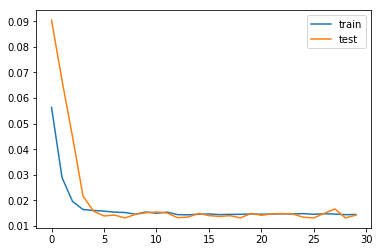

In [13]:
# plot history
plt.plot(historyr.history['loss'], label='train')
plt.plot(historyr.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 32783 samples


W0601 10:47:33.881654 4599520704 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
8760/8760 - 3s - loss: 0.0584 - val_loss: 0.0512
Epoch 2/30
8760/8760 - 1s - loss: 0.0412 - val_loss: 0.0509
Epoch 3/30
8760/8760 - 1s - loss: 0.0274 - val_loss: 0.0591
Epoch 4/30
8760/8760 - 1s - loss: 0.0182 - val_loss: 0.0515
Epoch 5/30
8760/8760 - 1s - loss: 0.0156 - val_loss: 0.0376
Epoch 6/30
8760/8760 - 3s - loss: 0.0148 - val_loss: 0.0306
Epoch 7/30
8760/8760 - 3s - loss: 0.0144 - val_loss: 0.0231
Epoch 8/30
8760/8760 - 1s - loss: 0.0143 - val_loss: 0.0211
Epoch 9/30
8760/8760 - 1s - loss: 0.0143 - val_loss: 0.0200
Epoch 10/30
8760/8760 - 1s - loss: 0.0142 - val_loss: 0.0184
Epoch 11/30
8760/8760 - 2s - loss: 0.0141 - val_loss: 0.0182
Epoch 12/30
8760/8760 - 1s - loss: 0.0141 - val_loss: 0.0175
Epoch 13/30
8760/8760 - 1s - loss: 0.0142 - val_loss: 0.0166
Epoch 14/30
8760/8760 - 2s - loss: 0.0141 - val_loss: 0.0168
Epoch 15/30
8760/8760 - 2s - loss: 0.0141 - val_loss: 0.0164
Epoch 16/30
8760/8760 - 2s - loss: 0.0141 - val_loss: 0.0164
Epoch 17/30
8760/8760 - 2s - loss

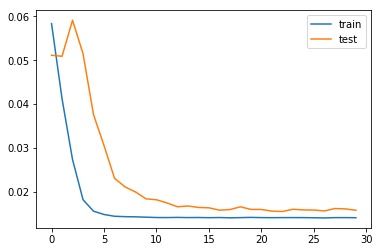

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
# design network
modeld = Sequential()
modeld.add(Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
modeld.add(Dense(500,activation='relu'))
modeld.add(Dense(1))
modeld.compile(loss='mae', optimizer='adam')
modeld.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               4500      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 501       
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit network
history = modeld.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 32783 samples
Epoch 1/50
8760/8760 - 1s - loss: 0.0355 - val_loss: 0.0296
Epoch 2/50
8760/8760 - 1s - loss: 0.0175 - val_loss: 0.0195
Epoch 3/50
8760/8760 - 1s - loss: 0.0164 - val_loss: 0.0184
Epoch 4/50
8760/8760 - 1s - loss: 0.0161 - val_loss: 0.0195
Epoch 5/50
8760/8760 - 2s - loss: 0.0150 - val_loss: 0.0175
Epoch 6/50
8760/8760 - 2s - loss: 0.0150 - val_loss: 0.0172
Epoch 7/50
8760/8760 - 1s - loss: 0.0151 - val_loss: 0.0166
Epoch 8/50
8760/8760 - 2s - loss: 0.0151 - val_loss: 0.0196
Epoch 9/50
8760/8760 - 1s - loss: 0.0154 - val_loss: 0.0170
Epoch 10/50
8760/8760 - 2s - loss: 0.0154 - val_loss: 0.0172
Epoch 11/50
8760/8760 - 2s - loss: 0.0147 - val_loss: 0.0184
Epoch 12/50
8760/8760 - 4s - loss: 0.0148 - val_loss: 0.0175
Epoch 13/50
8760/8760 - 2s - loss: 0.0150 - val_loss: 0.0192
Epoch 14/50
8760/8760 - 1s - loss: 0.0171 - val_loss: 0.0176
Epoch 15/50
8760/8760 - 1s - loss: 0.0163 - val_loss: 0.0227
Epoch 16/50
8760/8760 - 2s - loss: 0.0149 - v

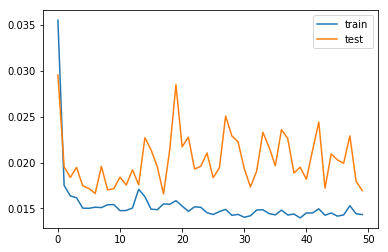

In [20]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
yhat = model.predict(test_X)
yhatd = modeld.predict(test_X)
yhatr = modelr.predict(test_X)

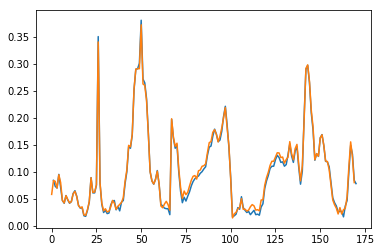

In [22]:
plt.plot(1+np.arange(len(test_y[:170])),test_y[:170])
plt.plot(np.arange(len(test_y[:170])),yhatr[:170,0])

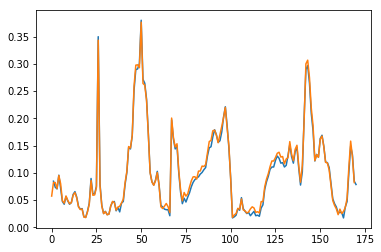

In [23]:
plt.plot(1+np.arange(len(test_y[:170])),test_y[:170])
plt.plot(np.arange(len(test_y[:170])),yhat[:170,0])
#plt.plot(np.arange(len(test_y[:150])),yhatd[:150,0])

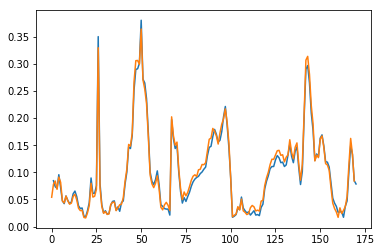

In [24]:
plt.plot(1+np.arange(len(test_y[:170])),test_y[:170])
#plt.plot(np.arange(len(test_y[:150])),yhat[:150,0])
plt.plot(np.arange(len(test_y[:170])),yhatd[:170,0])

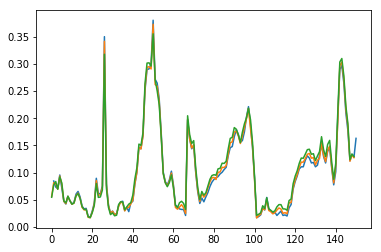

In [182]:
plt.plot(1+np.arange(len(test_y[:150])),test_y[:150])
plt.plot(np.arange(len(test_y[:150])),yhat[:150,0])
plt.plot(np.arange(len(test_y[:150])),yhatd[:150,0])

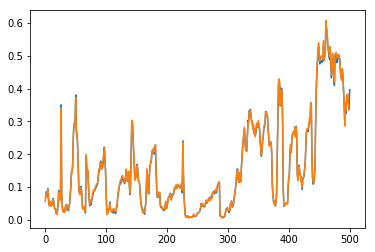

In [183]:
plt.plot(1+np.arange(len(test_y[:500])),test_y[:500])
plt.plot(np.arange(len(test_y[:500])),yhat[:500,0])
#plt.plot(np.arange(len(test_y[:500])),yhatd[:500,0])

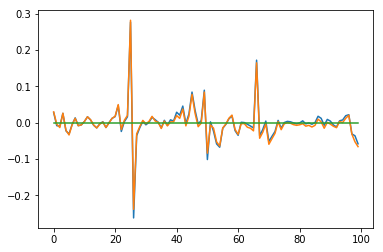

In [185]:
points=100
plt.plot(np.arange(len(test_y[:points])),test_y[:points]-yhat[:points,0])
plt.plot(np.arange(len(test_y[:points])),test_y[:points]-yhatd[:points,0])
plt.plot(np.arange(points),np.zeros(points))